In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch

In [2]:
def invert_pose(pose: torch.Tensor) -> torch.Tensor:
    rotation = pose[:3, :3]
    translation = pose[:3, -1]

    stack = torch.hstack([rotation.T, -1.0 * rotation.T @ translation[:, None]])
    padding = torch.hstack([torch.zeros(3), torch.ones(1)])

    return torch.vstack([stack, padding]) 

In [3]:
K = torch.as_tensor([[638.0, 0.0, 300],
                [0.0,  637.0,  295],
                [0.0, 0.0, 1.0]])

In [5]:
image_a = cv2.imread("dataset/rgbs/9_rgb.png") / 255
mask_a = torch.as_tensor(cv2.imread("dataset/masks/9_mask.png") / 255, dtype=torch.float32)
pose_a = torch.as_tensor(np.loadtxt("dataset/extrinsics_cam_to_world/9_pose.txt"), dtype=torch.float32)
depth_a = torch.as_tensor(np.load("dataset/depths/9_depth.npy"))

In [7]:
image_b = cv2.imread("dataset/rgbs/81_rgb.png") / 255
mask_b = torch.as_tensor(cv2.imread("dataset/masks/81_mask.png") / 255, dtype=torch.float32)
pose_b = torch.as_tensor(np.loadtxt("dataset/extrinsics_cam_to_world/81_pose.txt"), dtype=torch.float32)
depth_b = torch.as_tensor(np.load("dataset/depths/81_depth.npy"), dtype=torch.float32)

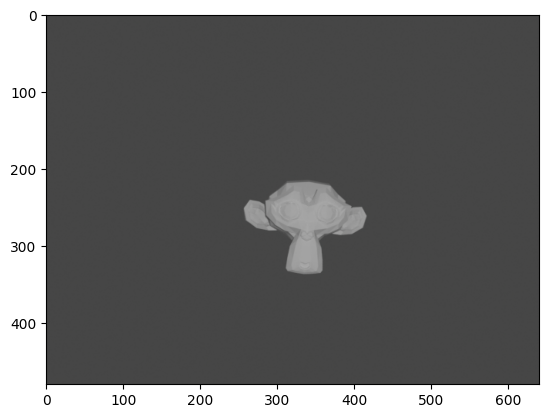

In [13]:
plt.imshow(image_a)

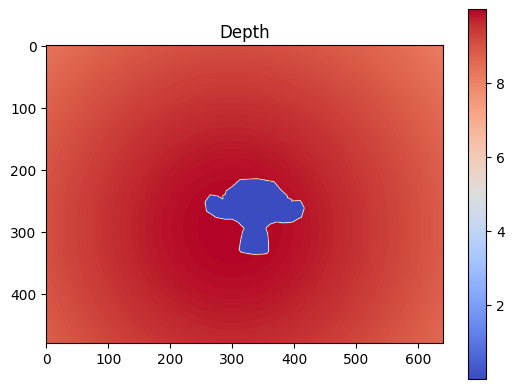

In [29]:
from matplotlib import cm
data = plt.imshow(np.load("dataset/depths/9_depth.npy") / 1000, cmap=cm.coolwarm)
plt.title("Depth")
plt.colorbar(data)

In [8]:
valid_pixels_a = torch.where(mask_a == 1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


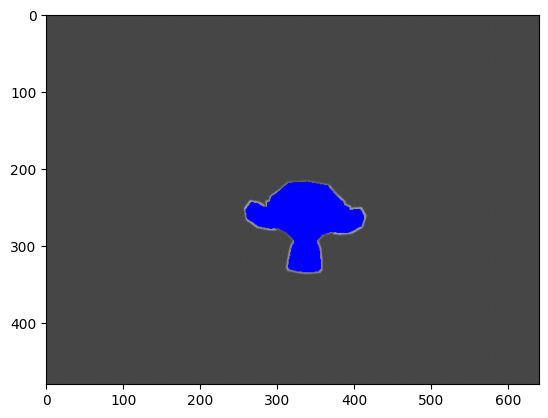

In [9]:
image = deepcopy(image_a)
list_world_coords = []

for u, v in zip(valid_pixels_a[0], valid_pixels_a[1]):
    image = cv2.circle(image, (v.item(),u.item()), radius=0, color=(0, 0, 255), thickness=-1)
    depth = depth_a[u, v] + 1e-6
    cam_coords = torch.linalg.inv(K) @ (depth * torch.vstack([u, v, torch.ones(1, dtype=torch.float32)]))
    world_coords = (pose_a) @ torch.vstack([cam_coords, torch.ones(1, dtype=torch.float32)])
    list_world_coords.append(world_coords[:3].reshape((1, 3)))

    
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


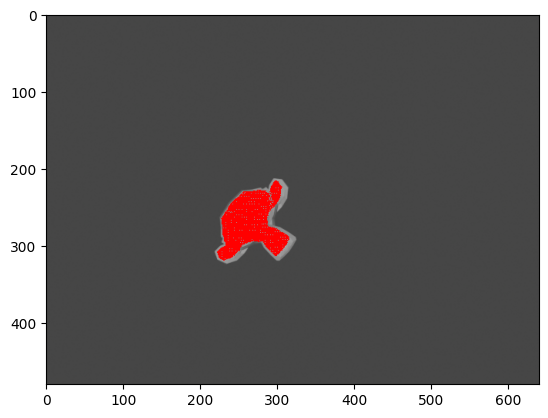

In [10]:
image = deepcopy(image_b)

for coord in list_world_coords:
    cam_coord = invert_pose(pose_b) @ np.vstack([coord.T, 1.0])
    duvb = K @ cam_coord[:3].type(torch.float32)

    depth = duvb[-1]
    uvb = duvb[:2] / depth

    uvb = uvb.type(torch.int64)

    if torch.allclose(mask_b[uvb[0].item(),uvb[1].item()], torch.ones(1)):

        image = cv2.circle(image, (uvb[1].item(),uvb[0].item()), radius=0, color=(255, 0, 0), thickness=-1)

plt.imshow(image)